# Tishkoff plots of selected regions

In [1]:
import re, os, sys, pickle, math, io
from functools import partial
from collections import defaultdict
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame
import pyfaidx
from ete3 import Tree, NodeStyle, TreeStyle, TextFace
import skbio

from multiprocessing import Pool, cpu_count

# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

numpy.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle, Circle, Ellipse, Patch
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print("{:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))

Directories:

In [4]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
#pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

reference_genome_file = Path('/home', 'kmt', 'simons', 
                        'faststorage', 'cteam_lite_public3', 'FullyPublic', 'Href.fa')
chimp_genome_file = Path('/home', 'kmt', 'simons', 
                        'faststorage', 'cteam_lite_public3', 'FullyPublic', 'Chimp.fa')

Import variables global to the entire analysis:

In [5]:
import analysis_globals

Local code:

In [6]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

### Meta data

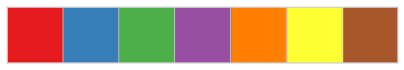

In [7]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')

my_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
                          '#ff7f00', '#ffff33', '#a65628']
# mute colors a bit:
sns.color_palette(my_colors, desat=0.85).as_hex()

region_colors = dict(zip(list(region_categories), 
                         my_colors))

sns.palplot(sns.color_palette(my_colors))

### Indexes of fasta files with male haploids

In [8]:
reference_index = pyfaidx.Fasta(str(reference_genome_file), 
                                     strict_bounds=True, 
                                     one_based_attributes=False)

chimp_index = pyfaidx.Fasta(str(chimp_genome_file), 
                                     strict_bounds=True, 
                                     one_based_attributes=False)
file_index = dict()
for file_path in male_x_haploid_dir.glob('*.fa'):
    name = file_path.name.split('.')[0]
    file_index[name] = pyfaidx.Fasta(str(file_path), 
                                     strict_bounds=True, 
                                     one_based_attributes=False)

In [9]:
male_x_admix_segments = pandas.read_hdf(results_dir / 'male_x_admix_segments.hdf')
#male_x_admix_segments.loc[lambda df: df.name == 'S_Papuan-12'] # head(100)

### Plotting code

UPGMA implementation:

In [10]:
def find_lowest_cell(table):
    x = 1
    y = 0
    min_val = table[x][y]
    for i in range(len(table)):
        for j in range(len(table[i])):
            if table[i][j] < min_val:
                min_val = table[i][j]
                x = i
                y = j
    return [x, y]

def link(x, y, wx, wy):
    return (x * wx + y * wy) / (wx + wy)

def update_table(table, a, b, weight_a, weight_b):
    for i in range(0, b):
        table[b][i] = link(table[b][i], table[a][i], weight_b, weight_a)
    for j in range(b+1, a):
        table[j][b] = link(table[j][b], table[a][j], weight_b, weight_a)
    for i in range(a+1, len(table)):
        table[i][b] = link(table[i][b], table[i][a], weight_b, weight_a)
    for i in range(a+1, len(table)):
        del table[i][a]
    del table[a] 

def update_labels(labels, i, j, di, dj):
    labels[j] = "({}:{},{}:{})".format(labels[j], dj, labels[i], di)
    del labels[i]

def upgma(mat, names):

    table = mat[:]
    labels = names[:]
    node_heights = [0 for _ in labels]

    while len(labels) > 1:
        i, j = find_lowest_cell(table)
        
        dist = table[i][j]

        wi = max(1, labels[i].count(':'))
        wj = max(1, labels[j].count(':'))

        new_node_height = dist / 2
        di = new_node_height - node_heights[i]
        dj = new_node_height - node_heights[j]
        
        update_table(table, i, j, wi, wj)
        update_labels(labels, i, j, di, dj)
        node_heights[j] = new_node_height
        del node_heights[i]
        
    return labels[0] + ';'

In [11]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
from Bio.Phylo import NewickIO

def jc(seq1, seq2):
    assert len(seq1) == len(seq2), (len(seq1), len(seq2))
    tot, diff = 0, 0
    for x, y in zip(seq1, seq2):
        if x in 'ATCG' and y in 'ATCG':
            if x != y:
                diff += 1
            tot += 1    
    if diff:
        distance = -3/4 * math.log(1 - 4/3 * diff/tot)
    else:
        distance = 0.0
    return distance


# def dist_matrix(seq_list):
#     n = len(seq_list)
#     mat = numpy.zeros((n, n))
#     for i in range(n):
#         for j in range(i, n):
#             mat[i][j] = jc(seq_list[i], seq_list[j])
#             mat[j][i] = mat[i][j]
#     return mat


def dist_matrix(seq_list):
    n = len(seq_list)
    mat = numpy.zeros((n, n))

    upper_trag_idx = list(zip(*numpy.triu_indices(n, k=1)))
    seq_pairs = [(seq_list[i], seq_list[j]) for i, j in upper_trag_idx]

    with Pool(int(os.environ['SLURM_CPUS_PER_TASK'])) as p:
        jc_distances = p.starmap(jc, seq_pairs)

    for (i, j), d in zip(upper_trag_idx, jc_distances):
        mat[i][j] = d
        mat[j][i] = mat[i][j]

    return mat

# def dist(seq1, seq2_list):
#     n = len(seq_list)
#     mat = numpy.zeros((n, n))
    
#     upper_trag_idx = list(zip(*numpy.triu_indices(n, k=1)))
#     seq_pairs = [(seq_list[i], seq_list[j]) for i, j in upper_trag_idx]
#     jc_distances = dview.map_sync(jc, *zip(*seq_pairs))
#     for (i, j), d in zip(upper_trag_idx, jc_distances):
#         mat[i][j] = d
#         mat[j][i] = mat[i][j]
# #     for i in range(n):
# #         for j in range(i, n):
# #             mat[i][j] = jc(seq_list[i], seq_list[j])
# #             mat[j][i] = mat[i][j]

#     return mat

def get_sequence_windows(sample_ids, start, end):
    assert start < end
    start, end = int(start), int(end)
    seq_list = list()
    name_list = list()

    for sample_id in sample_ids:
        name = sample_id + '-A'   
        seq_list.append(file_index[name]['X'][start:end].seq)
        name_list.append(name.replace('-A', ''))
        
#     seq_list.append(chimp_index['X'][start:end].seq)
#     name_list.append('Chimp')
    return name_list, seq_list

# def tree_newick(name_list, seq_list):
#     dm = skbio.DistanceMatrix(dist_matrix(seq_list).tolist(), name_list)
#     newick_str = skbio.tree.nj(dm, disallow_negative_branch_length=True, result_constructor=str)
#     return newick_str

# def tree_newick(name_list, seq_list):
#     mat = dist_matrix(seq_list).tolist()
#     lowtri = [lst[:i+1] for (i, lst) in enumerate(mat)]
#     dm = DistanceMatrix(name_list, lowtri)    
#     constructor = DistanceTreeConstructor()
#     tree = constructor.upgma(dm)
#     #tree = constructor.nj(dm)
#     output = io.StringIO()
#     NewickIO.write([tree], output)
#     contents = output.getvalue().strip()
#     newick_str = re.sub(r'Inner\d+', '', contents)
#     return newick_str

def tree_newick(name_list, seq_list):
    mat = dist_matrix(seq_list).tolist()
    lowtri = [lst[:i] for (i, lst) in enumerate(mat)]
    newick_str = upgma(lowtri, name_list)
    return newick_str

def get_non_ref_indexes(sample_name_list, seq_window_list, reference_window):
    non_ref_indexes = defaultdict(list)
    uncalled_indexes = defaultdict(list)
    for name, sample_window in zip(sample_name_list, seq_window_list):
        for i, (s, r) in enumerate(zip(sample_window, reference_window)):
            if s in 'ATGC' and r in 'ATGC':
                if s != r:
                    non_ref_indexes[name].append(i)
            else:
                uncalled_indexes[name].append(i)
    return non_ref_indexes, uncalled_indexes


def make_comb_tree(t):
    for node in t.traverse():
        if not node.is_leaf():
            node.children = sorted(node.children, key=lambda c: len(c.get_leaves()), reverse=False)
    

Drawing a tree:

In [12]:
def plot_tree(t, ax, leaf_colors=None, show_inner_nodes=False, fontsize=10, 
              text_offset=None, margins=(0.5, 1, 0.5, 1)): # top, right, bottom, left

    y_offset = len(t.get_leaves())
    for node in t.traverse("preorder"):
        node.x_offset = node.dist + sum(x.dist for x in node.get_ancestors())
        if node.is_leaf():
            y_offset -= 1
            node.y_offset = y_offset

    for node in t.traverse("postorder"):
        if not node.is_leaf():
            node.y_offset = sum(x.y_offset for x in node.children) / len(node.children)

    horizontal_lines = list()
    vertical_lines = list()
    node_coords = list()
    leaf_coords = list()
    max_x_offset = 0
    for node in t.traverse("postorder"):
        max_x_offset = max(max_x_offset, node.x_offset)
        node_coords.append((node.x_offset, node.y_offset))
        if node.is_leaf():
            leaf_coords.append([node.name, node.x_offset, node.y_offset])
        if not node.is_root():
            y = node.y_offset
            horizontal_lines.append(([node.up.x_offset, node.x_offset], [y, y]))
        if not node.is_leaf():
            c = sorted(node.children, key=lambda x: x.y_offset)
            bottom, top = c[0], c[-1]
            x = node.x_offset
            vertical_lines.append(([x, x],[bottom.y_offset, top.y_offset]))

    
    # shift the tree to put leaves at zero
    for i in range(len(horizontal_lines)):
        horizontal_lines[i][0][0] -= max_x_offset
        horizontal_lines[i][0][1] -= max_x_offset
    for i in range(len(vertical_lines)):
        vertical_lines[i][0][0] -= max_x_offset
        vertical_lines[i][0][1] -= max_x_offset
    for i in range(len(leaf_coords)):
        leaf_coords[i][1] -= max_x_offset
            
    # draw the tree:
    for x in horizontal_lines:
        ax.plot(*x, c='black', linewidth=0.8)
    for x in vertical_lines:
        ax.plot(*x, c='black', linewidth=0.8)

#     for tup in node_coords:
#         ax.plot(*tup, c='black', marker="o")

    if text_offset is None:
        text_offset = max_x_offset / 20
        
    for name, x, y in leaf_coords:
        ax.text(x+text_offset, y, name, fontsize=fontsize,
                verticalalignment='center', horizontalalignment='left')
        if leaf_colors is None:
            color = 'black'
        else:
            color = leaf_colors[name]
        ax.plot(x, y, c=color, marker="o", ms=3)


#     ax.set_xlim(-margins[3], max_x_offset + margins[1])
    ax.set_xlim(-margins[3]-max_x_offset, margins[1])
    ax.set_ylim(-margins[2], len(leaf_coords)-1+margins[0])


    #ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.spines['top'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['right'].set_visible(False)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    
    return leaf_coords

The Tishkoff plot:

In [13]:
from itertools import groupby
from operator import itemgetter

def tishkoff_plot(start, end, sample_ids, extra_data=None, plot_admix=True, figsize=(12, 10)):

    sample_name_list, seq_window_list = get_sequence_windows(sample_ids, start, end)
    reference_window = reference_index['X'][start:end].seq

    newick_str = tree_newick(sample_name_list, seq_window_list)
    tree = Tree(newick_str)

#     # remove chimp outgroup branches
#     tree.set_outgroup( tree&"Chimp" )
#     all_leaves = tree.get_leaf_names()
#     all_leaves.remove('Chimp')
#     tree.prune(all_leaves, preserve_branch_length=False)
    
    make_comb_tree(tree)

    non_ref_indexes, uncalled_indexes = get_non_ref_indexes(sample_name_list, seq_window_list, reference_window)
    
    leaf_colors = dict()
    for ind in individuals:
        leaf_colors[ind] = region_colors[individuals[ind]['Region']]

    leaf_colors['Ust_Ishim'] = 'grey'
#     leaf_colors['Chimp'] = 'black'

        
    with sns.axes_style('whitegrid'):

        if extra_data is None:
            fig = plt.figure(figsize=figsize) 
            gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
            ax0 = plt.subplot(gs[0])
            ax1 = plt.subplot(gs[1])
        else:
            fig = plt.figure(figsize=figsize) 
            gs = matplotlib.gridspec.GridSpec(1, 3, width_ratios=[2, 1, 2]) 
            ax0 = plt.subplot(gs[0])
            ax_extra = plt.subplot(gs[1])
            ax1 = plt.subplot(gs[2])


        leaf_info = plot_tree(tree, ax0, margins=(1, 0.0001, 1, 0.0001), 
                              fontsize=4, leaf_colors=leaf_colors)

        
        legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=10, 
                          label=reg, markerfacecolor=region_colors[reg]) for reg in region_categories]
        ax0.legend(handles=legend_elements, loc='lower left', prop={'size': 10})


        
        if extra_data is not None:

            with sns.axes_style('white'):
                names, x, y = zip(*leaf_info)
                copy_numbers = [extra_data(name) for name in names]
                ax_extra.barh(y, copy_numbers, color='lightgrey')


        for name, x, y in leaf_info:
            # plot the colored bar
            g = ax1.add_patch(Rectangle((0, y-0.5), end-start, 1, 
                                        facecolor=leaf_colors[name], 
                                        edgecolor=leaf_colors[name], 
                                        zorder=0))

            
            if plot_admix:
                # admix tracts
                admix_sgm = male_x_admix_segments.loc[lambda df: (df.name == name) & \
                                                  (df.start < end) & (df.end > start)]
                for tup in admix_sgm.itertuples():
                    s = tup.start - start
                    e = tup.end - start
                    g = ax1.add_patch(Rectangle((s, y-0.5), e-s, 1,
                                                facecolor='magenta',
                                                linewidth=0,
                                                zorder=2))

                    # Denisova SNPs with transparent dots around. 
                    if tup.Denisova:
                        for snp in map(int, tup.Denisova.split(',')):
                            snp -= start
                            ax1.add_line(Line2D((snp, snp), (y-0.5, y+0.5),
                                         color='white', solid_capstyle='butt', linewidth=0.5, zorder=4))                

            
#             # plot uncalled segments as lihgher areas
#             uncalled_segments = list()
#             for k, g in groupby(list(enumerate(uncalled_indexes[name])), lambda x: x[0]-x[1]):
#                 l = list(map(itemgetter(1), g))
#                 uncalled_segments.append((l[0], l[-1]))
#             for s, e in uncalled_segments:
#                 g = ax1.add_patch(Rectangle((s, y-0.5), e-s, 1,
#                                             facecolor='white', 
#                                             linewidth=0,
#                                             alpha=0.3,
#                                             zorder=2))

            # plot snps
            for p in non_ref_indexes[name]:
                ax1.add_line(Line2D((p, p), (y-0.5, y+0.5),
                                    color='black', solid_capstyle='butt', linewidth=0.5, zorder=3))                


        ax1.set_xlim(0, end-start)
        ax1.set_ylim(ax0.get_ylim())

        ax1.get_yaxis().set_visible(False)
        
        def format_func(value, tick_number):
            if value % 100000:
                return '' # only ticks for even 100
            return "{:.1f}".format((value + start)/1000000)

        ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

        ax1.grid(False)
           
        ax1.spines['top'].set_visible(False) 
        ax1.spines['left'].set_visible(False) 
        ax1.spines['right'].set_visible(False) 
        ax1.spines['bottom'].set_visible(False) 

        if extra_data is not None:
            ax_extra.set_xlim(0, max(copy_numbers)+max(copy_numbers)*0.1)
            ax_extra.set_ylim(ax0.get_ylim())

            ax_extra.get_yaxis().set_visible(False)
            ax_extra.spines['top'].set_visible(False) 
            ax_extra.spines['left'].set_visible(False) 
            ax_extra.spines['right'].set_visible(False) 

        plt.tight_layout()    

        return fig

## Data

In [14]:
sweep_peaks = pandas.read_hdf(results_dir / 'sweep_peaks.hdf')
sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')
male_indivs = sweep_data.indiv_1.unique()
len(male_indivs)

162

Load 90% extended regions that have enough individuals sweept that we call them as sweeps:

In [15]:
extended_peak_regions = (pandas.read_hdf(results_dir / 'extended_peak_regions_90%.hdf')
                        )
extended_peak_regions.swept_indivs = [eval(x) for x in extended_peak_regions.swept_indivs]
extended_peak_regions.head()

,pos,peak_start,peak_end,start_pos,end_pos,prop_swept,swept_indivs
0,11300000.0,11200000,11400000,11100000,11500000,0.328571,"[B_Australian-4, S_Adygei-1, S_Aleut-1, S_Burm..."
1,14750000.0,14700000,14800000,14700000,14900000,0.407143,"[B_Australian-4, B_Dai-4, B_Papuan-15, S_Abkha..."
2,19850000.0,19800000,19900000,19600000,20200000,0.757143,"[B_Australian-4, B_Crete-2, B_Dai-4, B_French-..."
3,21250000.0,21200000,21300000,21100000,21600000,0.778571,"[B_Australian-4, B_Crete-2, B_French-3, B_Han-..."
4,36250000.0,36200000,36300000,36000000,36400000,0.642857,"[B_Crete-2, B_Dai-4, B_French-3, B_Han-3, B_Ka..."


## Plot of a regions with prop_swept below 20%

In [16]:

fig = tishkoff_plot(84200000, 84700000, male_indivs, plot_admix=False)
plt.savefig(str(figures_dir / 'test.pdf'))
plt.close()

## Add Ust Ishim to male individuals

In [16]:
if 'Ust_Ishim' not in male_indivs: # precaution if ran more than once
    male_indivs = list(male_indivs) + ['Ust_Ishim']

## Plots for main paper

Plot without admixture segments:

In [18]:
fig = tishkoff_plot(100000000, 100005000, male_indivs, plot_admix=False)
fig.suptitle('A', fontsize=20, x=0, y=1, horizontalalignment='left', verticalalignment='top')

plt.savefig(str(figures_dir / 'test.pdf'))
plt.close()

In [20]:
for tup in extended_peak_regions.itertuples():
    prop_swept = '{:.0f}'.format(tup.prop_swept * 100)    
    pos = int(tup.pos)
    if pos in [55500000, 110900000]:
        fig = tishkoff_plot( tup.start_pos, tup.end_pos, male_indivs, plot_admix=False, figsize=(9, 10))
        plt.savefig(str(figures_dir / 'main_haplo_visual_{:09}_{:09}_{}.pdf'.format(tup.start_pos, tup.end_pos, prop_swept)))
        plt.close()

500kb plot outside any sweeps for comparison:

In [21]:
pos = 29950000
win_start, win_end = pos - 250000, pos + 250000 
fig = tishkoff_plot(win_start, win_end, male_indivs, plot_admix=False, figsize=(9, 10))
plt.savefig(str(figures_dir / 'haplo_visual_background_{:09}_{:09}.pdf'.format(win_start, win_end)))
plt.close()

## Plots for supplementary

In [17]:
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ$%&#'

In [23]:
for i, tup in enumerate(extended_peak_regions.itertuples()):
    prop_swept = '{:.0f}'.format(tup.prop_swept * 100)
    pos = int(tup.pos)        
    fig = tishkoff_plot( tup.start_pos, tup.end_pos, male_indivs, plot_admix=False)
    fig.suptitle(letters[i], fontsize=20, x=0, y=1, horizontalalignment='left', verticalalignment='top')
    plt.savefig(str(figures_dir / 'haplo_visual_{:09}_{:09}_{}.pdf'.format(tup.start_pos, tup.end_pos, prop_swept)))
    plt.close()

Same but showing admix segments too (not for supplementary):

In [18]:
for i, tup in enumerate(extended_peak_regions.itertuples()):    
    prop_swept = '{:.0f}'.format(tup.prop_swept * 100)
    pos = int(tup.pos)
    fig = tishkoff_plot( tup.start_pos, tup.end_pos, male_indivs, plot_admix=True)
    fig.suptitle(letters[i], fontsize=20, x=0, y=1, horizontalalignment='left', verticalalignment='top')
    plt.savefig(str(figures_dir / 'haplo_visual_with_admix_{:09}_{:09}_{}.pdf'.format(tup.start_pos, tup.end_pos, prop_swept)))
    plt.close()

### Plots for Elise with copy numbers